In [17]:
# Cell 1: Install Required Packages
!pip install transformers torch torchaudio librosa soundfile numpy pandas scikit-learn faiss-cpu seaborn matplotlib

In [18]:
# Cell 2: Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
import torch
import torchaudio
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import faiss
import soundfile as sf
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')

print("All libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All libraries imported successfully!


#Load and Explore Audio Data

In [20]:
# Cell 3: Load and Explore Audio Data
audio_folder = "/content/drive/MyDrive/Audio data "

# Get all audio files
audio_files = [f for f in os.listdir(audio_folder)
              if f.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))]

print(f"Found {len(audio_files)} audio files:")
print("=" * 50)

# Create a DataFrame for initial analysis
audio_info = []

for i, file_name in enumerate(audio_files):
    file_path = os.path.join(audio_folder, file_name)
    try:
        # Load audio to get basic info
        y, sr = librosa.load(file_path, sr=None)
        duration = len(y) / sr

        # Extract person label from filename (modify as needed)
        if 'person1' in file_name.lower() or '1' in file_name or 'speaker1' in file_name.lower():
            person = 'Person_1'
        elif 'person2' in file_name.lower() or '2' in file_name or 'speaker2' in file_name.lower():
            person = 'Person_2'
        else:
            person = f'Person_{i % 2 + 1}'  # Alternate assignment if no clear pattern

        audio_info.append({
            'File_Name': file_name,
            'Person': person,
            'Duration_Sec': round(duration, 2),
            'Sample_Rate': sr,
            'File_Size_MB': round(os.path.getsize(file_path) / (1024*1024), 2)
        })

        print(f"{i+1:2d}. {file_name[:40]:40s} | {person:8s} | {duration:6.2f}s | {sr:5d} Hz")

    except Exception as e:
        print(f"Error loading {file_name}: {str(e)}")

# Create DataFrame
df_audio = pd.DataFrame(audio_info)
print("\n" + "=" * 70)
print("AUDIO DATASET SUMMARY:")
print("=" * 70)
print(df_audio)

# Basic statistics
print("\n" + "=" * 70)
print("STATISTICS:")
print("=" * 70)
print(f"Total files: {len(df_audio)}")
print(f"Person distribution:")
print(df_audio['Person'].value_counts())
print(f"\nDuration statistics:")
print(df_audio['Duration_Sec'].describe())
print(f"\nSample rate distribution:")
print(df_audio['Sample_Rate'].value_counts())

Found 14 audio files:
 1. Recording_3.m4a                          | Person_1 |  23.49s | 16000 Hz
 2. Recording_2.m4a                          | Person_2 |  16.64s | 16000 Hz
 3. Recording_4.m4a                          | Person_1 |  16.70s | 16000 Hz
 4. Recording_5.m4a                          | Person_2 |  22.08s | 16000 Hz
 5. Recording_6.m4a                          | Person_1 |  30.14s | 16000 Hz
 6. Recording_7.m4a                          | Person_2 |  23.55s | 16000 Hz
 7. Recording_8.m4a                          | Person_1 |  21.82s | 16000 Hz
 8. Recording_9.m4a                          | Person_2 |  25.22s | 16000 Hz
 9. Recording_10.m4a                         | Person_1 |   4.03s | 16000 Hz
10. Recording_11.m4a                         | Person_1 |  19.20s | 16000 Hz
11. Recording_12.m4a                         | Person_1 |  13.44s | 16000 Hz
12. Recording_13.m4a                         | Person_1 |  23.23s | 16000 Hz
13. Recording_14.m4a                         | Person_

# Define Audio Processor Class

In [21]:
# Cell 4: Define Audio Processor Class
class BanglaAudioProcessor:
    def __init__(self, model_name="facebook/wav2vec2-large-xlsr-53"):
        """
        Initialize the audio processor with pre-trained wav2vec2 model
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading Wav2Vec2 model...")
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.model = Wav2Vec2Model.from_pretrained(model_name).to(self.device)
        self.model.eval()

        # Audio preprocessing parameters
        self.target_sr = 16000  # Wav2Vec2 expects 16kHz
        self.max_length = 10 * self.target_sr  # Max 10 seconds
        print("Model loaded successfully!")

    def load_and_preprocess_audio(self, file_path: str) -> np.ndarray:
        """Load and preprocess a single audio file"""
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=self.target_sr)

            # Normalize audio
            audio = librosa.util.normalize(audio)

            # Trim silence
            audio, _ = librosa.effects.trim(audio, top_db=20)

            # Pad or truncate to fixed length
            if len(audio) > self.max_length:
                audio = audio[:self.max_length]
            else:
                audio = np.pad(audio, (0, self.max_length - len(audio)))

            return audio

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    def extract_embeddings(self, audio: np.ndarray) -> np.ndarray:
        """Extract embeddings using Wav2Vec2 model"""
        with torch.no_grad():
            # Prepare input
            inputs = self.feature_extractor(
                audio,
                sampling_rate=self.target_sr,
                return_tensors="pt"
            )

            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Get model outputs
            outputs = self.model(**inputs)

            # Use mean of last hidden states as embedding
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()

            return embeddings.cpu().numpy()

    def extract_audio_features(self, audio: np.ndarray) -> Dict:
        """Extract additional audio features for analysis"""
        features = {}

        # Basic audio properties
        features['duration'] = len(audio) / self.target_sr
        features['rms_energy'] = np.sqrt(np.mean(audio**2))

        # Spectral features
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=audio, sr=self.target_sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr))
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(audio))

        # MFCC features (first 13 coefficients)
        mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}'] = np.mean(mfccs[i])

        return features

print("BanglaAudioProcessor class defined successfully!")

BanglaAudioProcessor class defined successfully!


#Initialize Processor and Extract Embeddings

In [22]:
# Cell 5: Initialize Processor and Extract Embeddings
print("Initializing Bangla Audio Processor...")
processor = BanglaAudioProcessor()

# Process all audio files
results = {
    'file_names': [],
    'person_labels': [],
    'embeddings': [],
    'audio_features': []
}

print(f"\nProcessing {len(audio_files)} audio files...")
print("=" * 60)

for i, file_name in enumerate(audio_files):
    file_path = os.path.join(audio_folder, file_name)
    print(f"Processing {i+1}/{len(audio_files)}: {file_name[:40]:<40}", end=" ... ")

    # Load and preprocess audio
    audio = processor.load_and_preprocess_audio(file_path)
    if audio is None:
        print("FAILED")
        continue

    # Extract embeddings
    try:
        embedding = processor.extract_embeddings(audio)
        features = processor.extract_audio_features(audio)

        # Determine person label
        if 'person1' in file_name.lower() or '1' in file_name or 'speaker1' in file_name.lower():
            person_label = 'Person_1'
        elif 'person2' in file_name.lower() or '2' in file_name or 'speaker2' in file_name.lower():
            person_label = 'Person_2'
        else:
            person_label = f'Person_{i % 2 + 1}'

        results['file_names'].append(file_name)
        results['person_labels'].append(person_label)
        results['embeddings'].append(embedding)
        results['audio_features'].append(features)

        print(f"SUCCESS (embedding dim: {len(embedding)})")

    except Exception as e:
        print(f"FAILED: {str(e)}")

print("\n" + "=" * 60)
print(f"Successfully processed: {len(results['embeddings'])}/{len(audio_files)} files")
print(f"Embedding dimension: {len(results['embeddings'][0]) if results['embeddings'] else 'N/A'}")

# Create embeddings DataFrame for analysis
if results['embeddings']:
    embeddings_array = np.array(results['embeddings'])
    print(f"Embeddings shape: {embeddings_array.shape}")

    # Create summary DataFrame
    df_results = pd.DataFrame({
        'File_Name': results['file_names'],
        'Person': results['person_labels'],
        'Embedding_Norm': [np.linalg.norm(emb) for emb in results['embeddings']]
    })

    print("\nProcessed Files Summary:")
    print(df_results)

Initializing Bangla Audio Processor...
Using device: cpu
Loading Wav2Vec2 model...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Model loaded successfully!

Processing 14 audio files...
Processing 1/14: Recording_3.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 2/14: Recording_2.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 3/14: Recording_4.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 4/14: Recording_5.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 5/14: Recording_6.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 6/14: Recording_7.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 7/14: Recording_8.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 8/14: Recording_9.m4a                          ... SUCCESS (embedding dim: 1024)
Processing 9/14: Recording_10.m4a                         ... SUCCESS (embedding dim: 1024)
Processing 10/14: Recording_11.m4a                         ... SUCCESS (embedding dim: 1024)
Processing 11/14: Reco

#Calculate Similarity Matrix and Distances

In [23]:
# Cell 6: Calculate Similarity Matrix and Distances
if not results['embeddings']:
    print("No embeddings available for analysis!")
else:
    embeddings_array = np.array(results['embeddings'])

    # Calculate cosine similarity matrix
    print("Calculating cosine similarity matrix...")
    similarity_matrix = cosine_similarity(embeddings_array)

    # Calculate cosine distance matrix (1 - cosine similarity)
    distance_matrix = 1 - similarity_matrix

    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    print(f"Similarity range: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")
    print(f"Distance range: [{distance_matrix.min():.4f}, {distance_matrix.max():.4f}]")

    # Create detailed similarity analysis
    similarity_data = []

    for i in range(len(results['embeddings'])):
        for j in range(i+1, len(results['embeddings'])):
            similarity = similarity_matrix[i][j]
            distance = distance_matrix[i][j]

            same_person = results['person_labels'][i] == results['person_labels'][j]

            similarity_data.append({
                'File_1': results['file_names'][i],
                'File_2': results['file_names'][j],
                'Person_1': results['person_labels'][i],
                'Person_2': results['person_labels'][j],
                'Same_Person': same_person,
                'Cosine_Similarity': similarity,
                'Cosine_Distance': distance
            })

    # Create DataFrame for detailed analysis
    df_similarity = pd.DataFrame(similarity_data)

    print(f"\nTotal pairs analyzed: {len(df_similarity)}")
    print("=" * 50)

    # Separate same-person vs different-person similarities
    same_person_pairs = df_similarity[df_similarity['Same_Person'] == True]
    diff_person_pairs = df_similarity[df_similarity['Same_Person'] == False]

    print("SIMILARITY STATISTICS:")
    print("=" * 50)
    print(f"Same Person Pairs: {len(same_person_pairs)}")
    if len(same_person_pairs) > 0:
        print(f"  Cosine Similarity - Mean: {same_person_pairs['Cosine_Similarity'].mean():.4f}, Std: {same_person_pairs['Cosine_Similarity'].std():.4f}")
        print(f"  Cosine Distance   - Mean: {same_person_pairs['Cosine_Distance'].mean():.4f}, Std: {same_person_pairs['Cosine_Distance'].std():.4f}")

    print(f"\nDifferent Person Pairs: {len(diff_person_pairs)}")
    if len(diff_person_pairs) > 0:
        print(f"  Cosine Similarity - Mean: {diff_person_pairs['Cosine_Similarity'].mean():.4f}, Std: {diff_person_pairs['Cosine_Similarity'].std():.4f}")
        print(f"  Cosine Distance   - Mean: {diff_person_pairs['Cosine_Distance'].mean():.4f}, Std: {diff_person_pairs['Cosine_Distance'].std():.4f}")

    print("\nTop 5 Most Similar Pairs:")
    print(df_similarity.nlargest(5, 'Cosine_Similarity')[['File_1', 'File_2', 'Same_Person', 'Cosine_Similarity']])

    print("\nTop 5 Most Different Pairs:")
    print(df_similarity.nsmallest(5, 'Cosine_Similarity')[['File_1', 'File_2', 'Same_Person', 'Cosine_Similarity']])

Calculating cosine similarity matrix...
Similarity matrix shape: (14, 14)
Similarity range: [0.9962, 1.0000]
Distance range: [-0.0000, 0.0038]

Total pairs analyzed: 91
SIMILARITY STATISTICS:
Same Person Pairs: 51
  Cosine Similarity - Mean: 0.9993, Std: 0.0010
  Cosine Distance   - Mean: 0.0007, Std: 0.0010

Different Person Pairs: 40
  Cosine Similarity - Mean: 0.9996, Std: 0.0006
  Cosine Distance   - Mean: 0.0004, Std: 0.0006

Top 5 Most Similar Pairs:
             File_1            File_2  Same_Person  Cosine_Similarity
66  Recording_8.m4a  Recording_12.m4a         True           0.999995
54  Recording_6.m4a  Recording_15.m4a         True           0.999994
15  Recording_2.m4a   Recording_6.m4a        False           0.999992
47  Recording_6.m4a   Recording_8.m4a         True           0.999991
69  Recording_8.m4a  Recording_15.m4a         True           0.999991

Top 5 Most Different Pairs:
              File_1            File_2  Same_Person  Cosine_Similarity
78  Recording_10.m4

#Visualize Similarity Matrix and Results

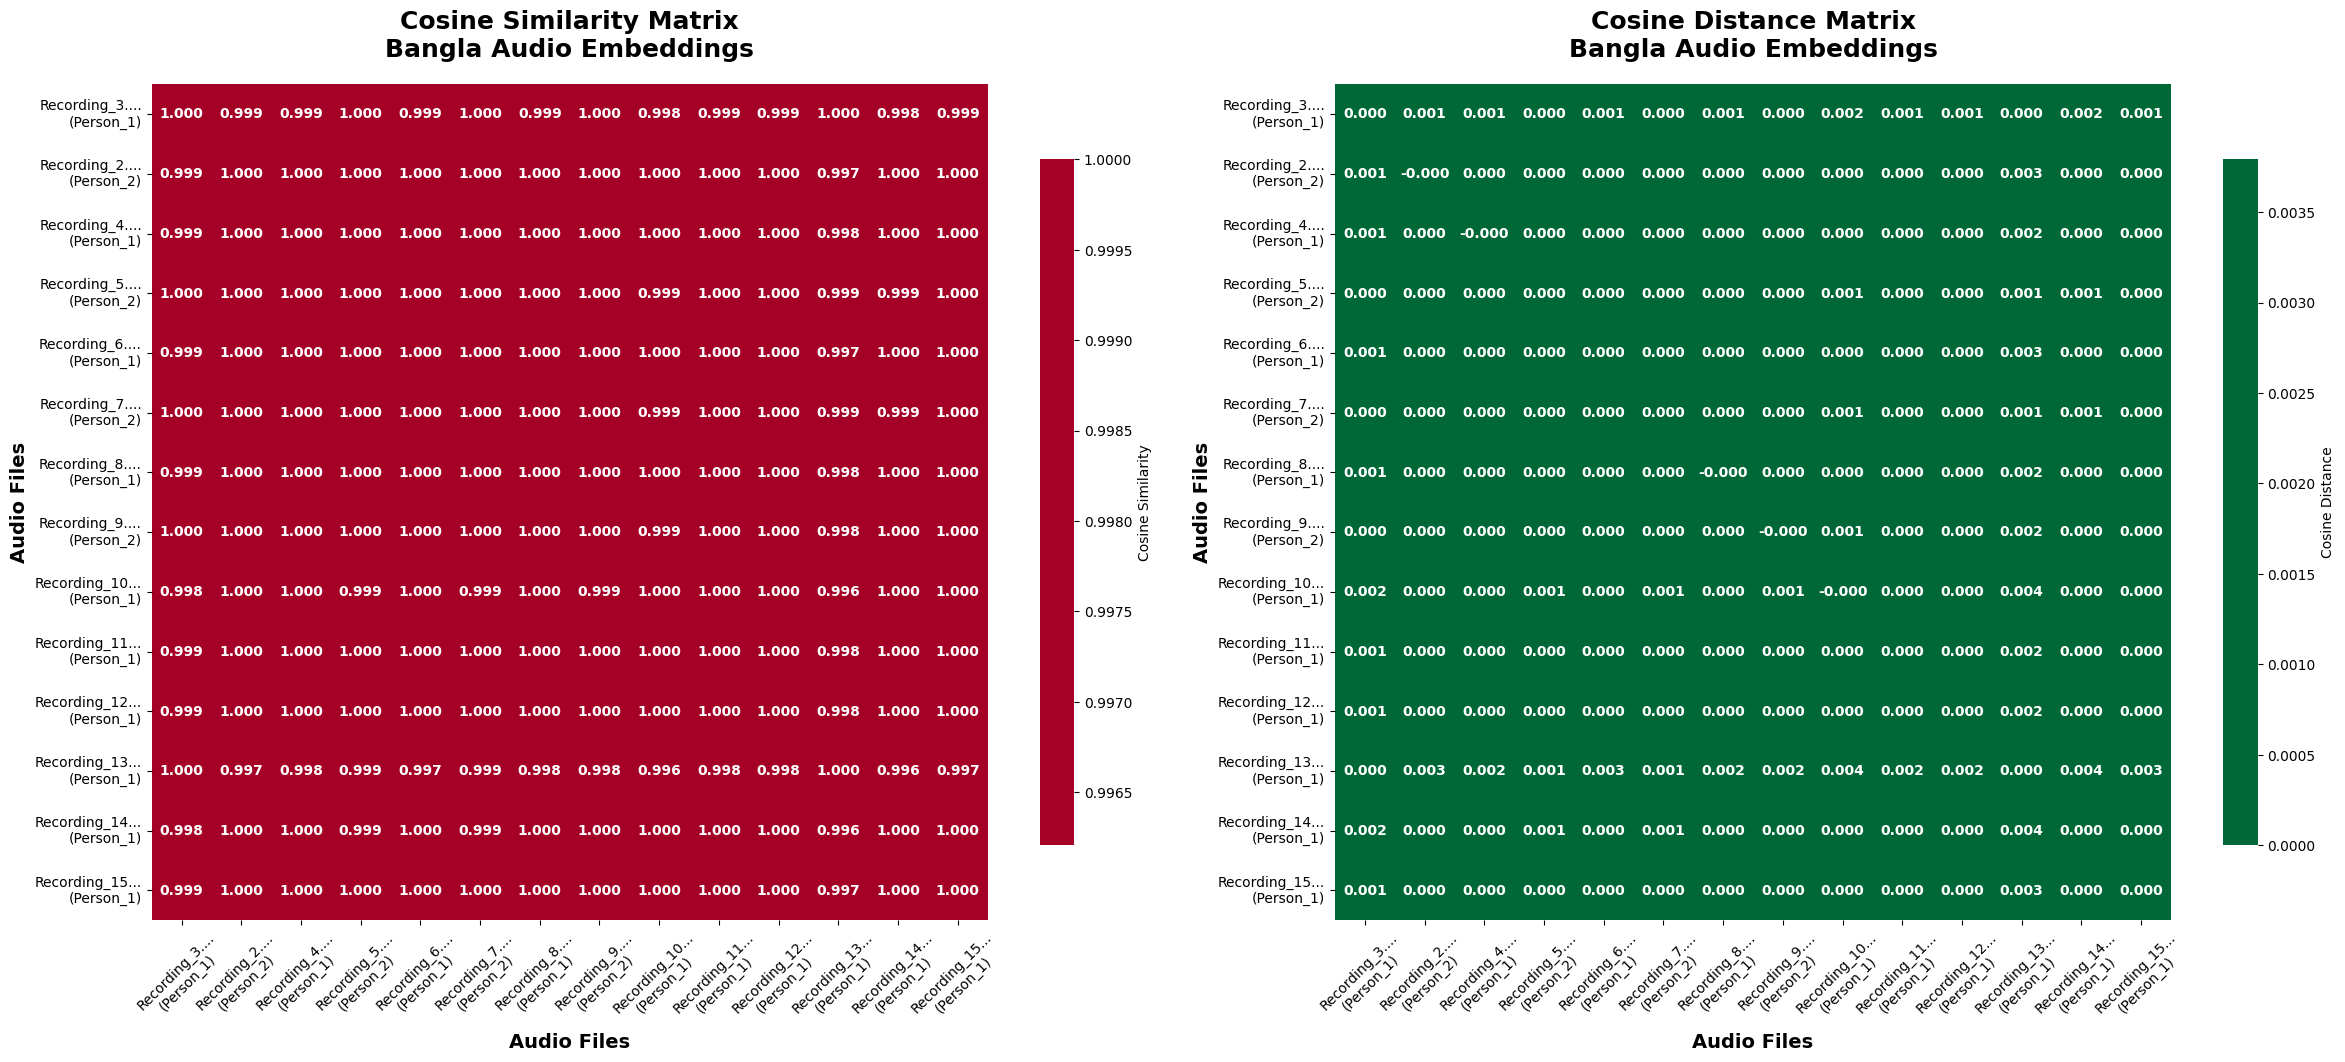

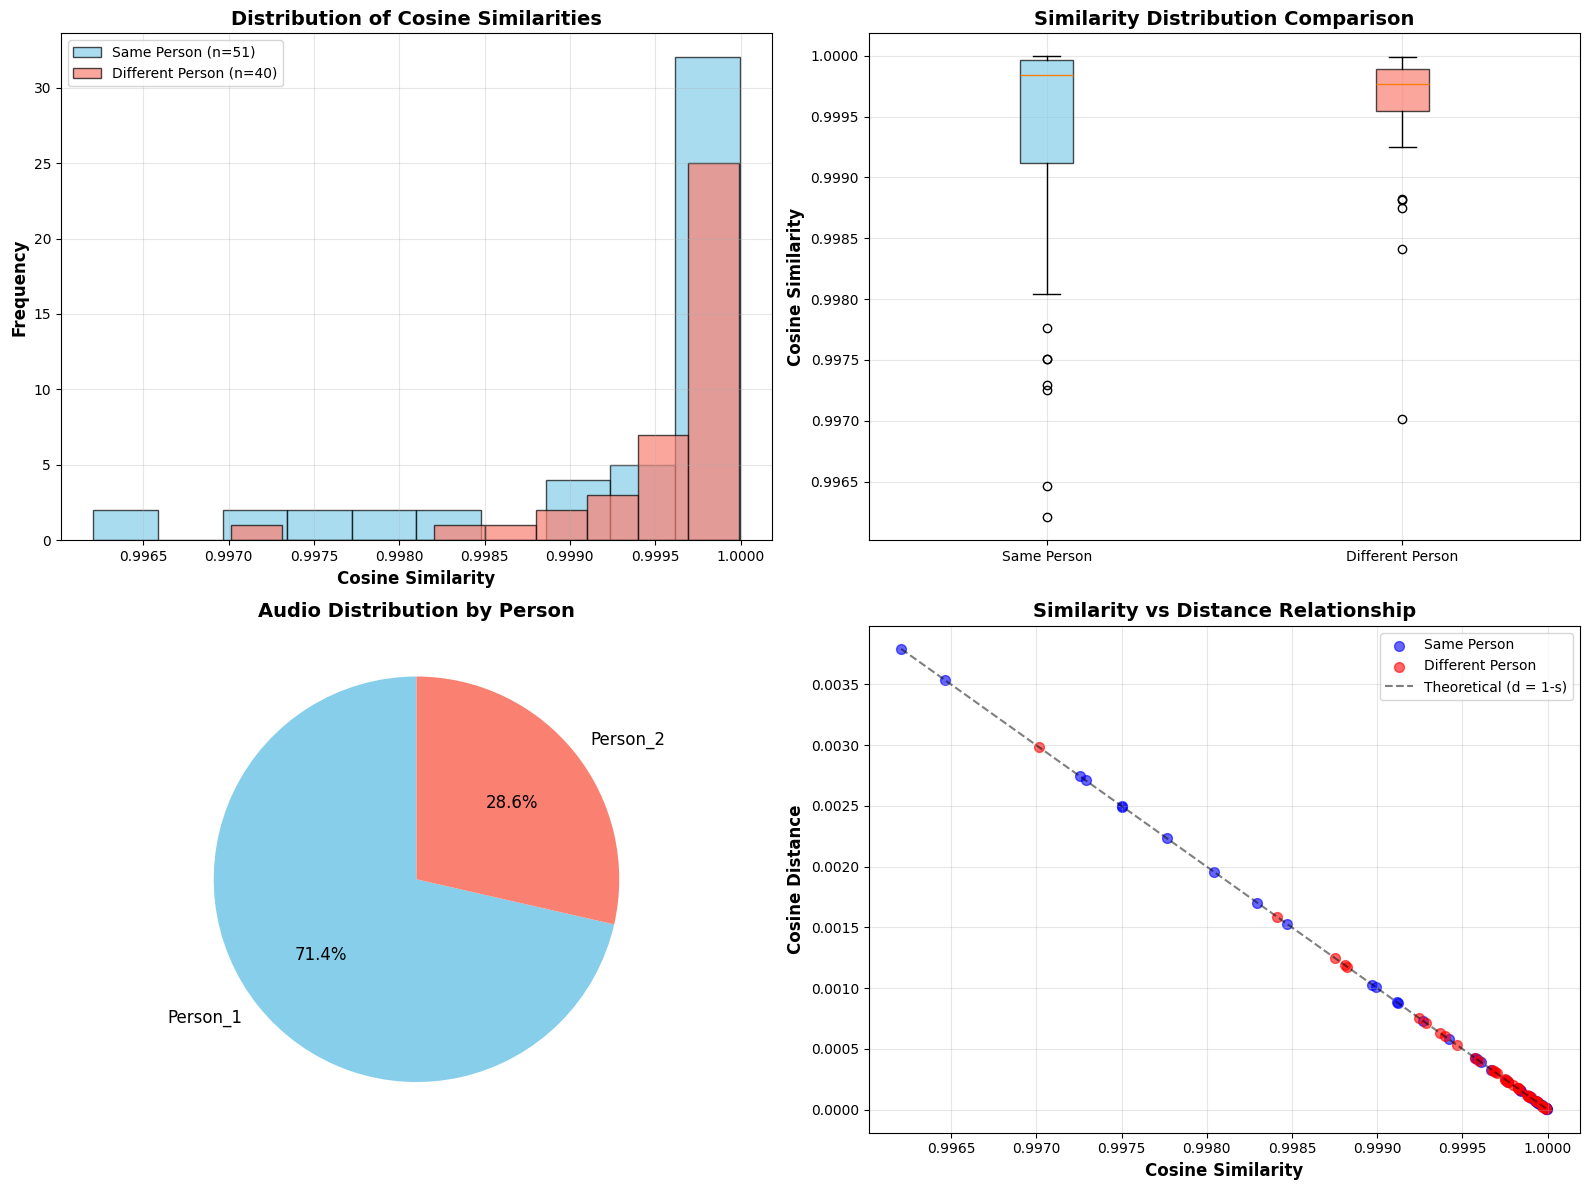

All visualizations generated successfully!


In [30]:
# Cell 7: Visualize Similarity Matrix and Results
if results['embeddings']:
    # Set up the plotting style
    plt.style.use('default')

    # Create labels for heatmap
    labels = []
    for i, (name, person) in enumerate(zip(results['file_names'], results['person_labels'])):
        short_name = name[:12] + "..." if len(name) > 12 else name
        labels.append(f"{short_name}\n({person})")

    # First, create larger heatmaps for similarity and distance matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # 1. Cosine Similarity Heatmap (LARGER)
    sns.heatmap(similarity_matrix,
                annot=True,
                cmap='RdYlBu_r',
                center=0.5,
                xticklabels=labels,
                yticklabels=labels,
                fmt='.3f',
                annot_kws={'size': 10, 'weight': 'bold'},
                cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.8},
                square=True,
                ax=ax1)

    ax1.set_title('Cosine Similarity Matrix\nBangla Audio Embeddings', fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Audio Files', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Audio Files', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)

    # 2. Cosine Distance Heatmap (LARGER)
    sns.heatmap(distance_matrix,
                annot=True,
                cmap='RdYlGn_r',
                center=0.5,
                xticklabels=labels,
                yticklabels=labels,
                fmt='.3f',
                annot_kws={'size': 10, 'weight': 'bold'},
                cbar_kws={'label': 'Cosine Distance', 'shrink': 0.8},
                square=True,
                ax=ax2)

    ax2.set_title('Cosine Distance Matrix\nBangla Audio Embeddings', fontsize=18, fontweight='bold', pad=20)
    ax2.set_xlabel('Audio Files', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Audio Files', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    ax2.tick_params(axis='y', rotation=0, labelsize=10)

    plt.tight_layout()
    plt.show()

    # Now create the other plots in a separate figure
    fig = plt.subplots(2, 2, figsize=(16, 12))[0]

    # 3. Distribution of Similarities
    ax3 = plt.subplot(2, 2, 1)

    if len(same_person_pairs) > 0:
        plt.hist(same_person_pairs['Cosine_Similarity'], bins=10, alpha=0.7,
                label=f'Same Person (n={len(same_person_pairs)})', color='skyblue', edgecolor='black')

    if len(diff_person_pairs) > 0:
        plt.hist(diff_person_pairs['Cosine_Similarity'], bins=10, alpha=0.7,
                label=f'Different Person (n={len(diff_person_pairs)})', color='salmon', edgecolor='black')

    plt.xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Box Plot of Similarities
    ax4 = plt.subplot(2, 2, 2)

    box_data = []
    box_labels = []

    if len(same_person_pairs) > 0:
        box_data.append(same_person_pairs['Cosine_Similarity'])
        box_labels.append('Same Person')

    if len(diff_person_pairs) > 0:
        box_data.append(diff_person_pairs['Cosine_Similarity'])
        box_labels.append('Different Person')

    if box_data:
        bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
        colors = ['skyblue', 'salmon']
        for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

    plt.ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
    plt.title('Similarity Distribution Comparison', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 5. Person-wise Analysis
    ax5 = plt.subplot(2, 2, 3)

    person_counts = pd.Series(results['person_labels']).value_counts()
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

    plt.pie(person_counts.values, labels=person_counts.index, autopct='%1.1f%%',
            colors=colors[:len(person_counts)], startangle=90, textprops={'fontsize': 12})
    plt.title('Audio Distribution by Person', fontsize=14, fontweight='bold')

    # 6. Similarity vs Distance Scatter Plot
    ax6 = plt.subplot(2, 2, 4)

    # Create scatter plot
    same_color = 'blue'
    diff_color = 'red'

    if len(same_person_pairs) > 0:
        plt.scatter(same_person_pairs['Cosine_Similarity'], same_person_pairs['Cosine_Distance'],
                   c=same_color, alpha=0.6, s=50, label='Same Person')

    if len(diff_person_pairs) > 0:
        plt.scatter(diff_person_pairs['Cosine_Similarity'], diff_person_pairs['Cosine_Distance'],
                   c=diff_color, alpha=0.6, s=50, label='Different Person')

    plt.xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
    plt.ylabel('Cosine Distance', fontsize=12, fontweight='bold')
    plt.title('Similarity vs Distance Relationship', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add diagonal line (theoretical relationship: distance = 1 - similarity)
    x = np.linspace(similarity_matrix.min(), similarity_matrix.max(), 100)
    plt.plot(x, 1-x, 'k--', alpha=0.5, label='Theoretical (d = 1-s)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("All visualizations generated successfully!")
else:
    print("No data available for visualization!")

#Advanced Analysis - Clustering and Dimensionality Reduction

Performing advanced analysis...
Computing t-SNE...
Performing K-Means clustering...


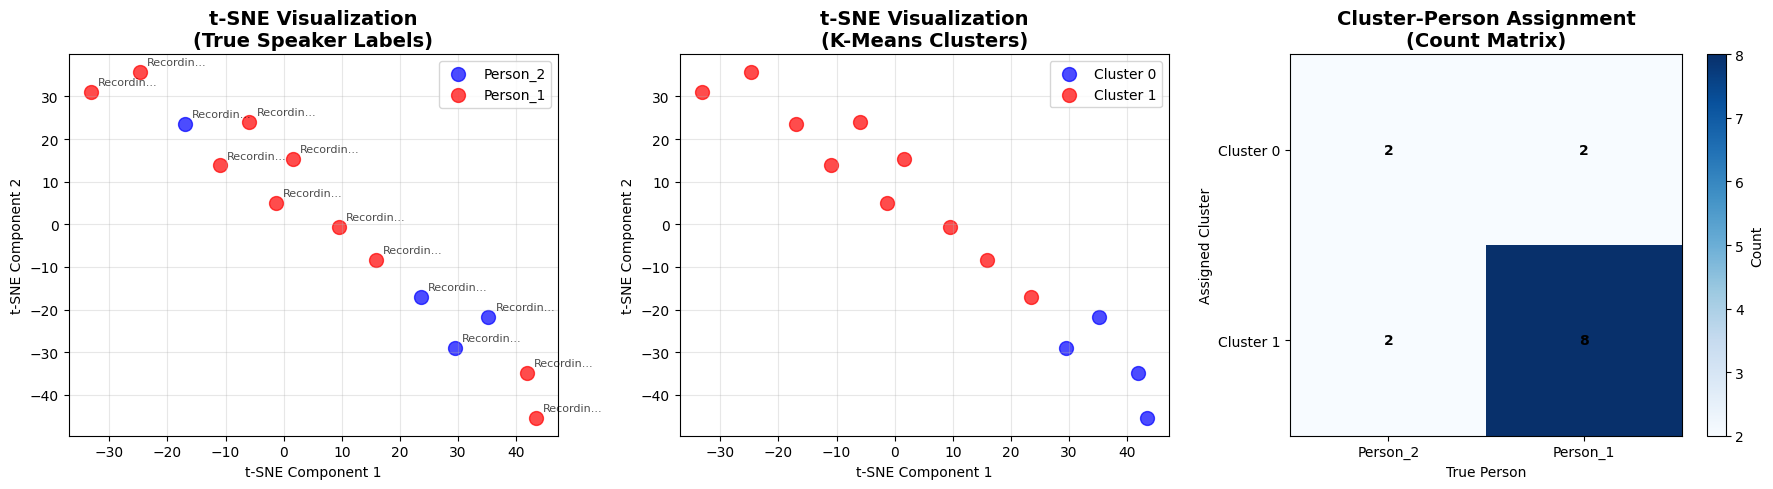


CLUSTERING ANALYSIS:
Clustering Accuracy: 71.43%

Cluster 0: 4 files
  - Recording_3.m4a                (Person_1)
  - Recording_5.m4a                (Person_2)
  - Recording_7.m4a                (Person_2)
  - Recording_13.m4a               (Person_1)

Cluster 1: 10 files
  - Recording_2.m4a                (Person_2)
  - Recording_4.m4a                (Person_1)
  - Recording_6.m4a                (Person_1)
  - Recording_8.m4a                (Person_1)
  - Recording_9.m4a                (Person_2)
  - Recording_10.m4a               (Person_1)
  - Recording_11.m4a               (Person_1)
  - Recording_12.m4a               (Person_1)
  - Recording_14.m4a               (Person_1)
  - Recording_15.m4a               (Person_1)

EMBEDDING SPACE ANALYSIS:
Intra-person distances (same speaker):
  Mean: 0.1351, Std: 0.1164
  Min: 0.0163, Max: 0.4254

Inter-person distances (different speakers):
  Mean: 0.1192, Std: 0.0740
  Min: 0.0195, Max: 0.3730

Separability Ratio (inter/intra): 0.8824
(

In [25]:
# Cell 8: Advanced Analysis - Clustering and Dimensionality Reduction
if results['embeddings']:
    print("Performing advanced analysis...")

    # 1. t-SNE Dimensionality Reduction
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(results['embeddings'])-1))
    embeddings_2d = tsne.fit_transform(embeddings_array)

    # 2. K-Means Clustering
    print("Performing K-Means clustering...")
    n_clusters = len(set(results['person_labels']))  # Number of unique persons
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_array)

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: t-SNE with true labels
    ax1 = axes[0]
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    unique_persons = list(set(results['person_labels']))

    for i, person in enumerate(unique_persons):
        mask = np.array(results['person_labels']) == person
        ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=colors[i % len(colors)], label=person, s=100, alpha=0.7)

    ax1.set_title('t-SNE Visualization\n(True Speaker Labels)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add file name annotations
    for i, (x, y) in enumerate(embeddings_2d):
        short_name = results['file_names'][i][:8] + "..." if len(results['file_names'][i]) > 8 else results['file_names'][i]
        ax1.annotate(short_name, (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

    # Plot 2: t-SNE with cluster labels
    ax2 = axes[1]
    unique_clusters = list(set(cluster_labels))

    for i, cluster in enumerate(unique_clusters):
        mask = cluster_labels == cluster
        ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=colors[i % len(colors)], label=f'Cluster {cluster}', s=100, alpha=0.7)

    ax2.set_title('t-SNE Visualization\n(K-Means Clusters)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Clustering accuracy analysis
    ax3 = axes[2]

    # Create confusion matrix-like analysis
    cluster_person_matrix = np.zeros((n_clusters, len(unique_persons)))

    for i, (cluster, person) in enumerate(zip(cluster_labels, results['person_labels'])):
        person_idx = unique_persons.index(person)
        cluster_person_matrix[cluster, person_idx] += 1

    im = ax3.imshow(cluster_person_matrix, cmap='Blues', aspect='auto')
    ax3.set_xticks(range(len(unique_persons)))
    ax3.set_yticks(range(n_clusters))
    ax3.set_xticklabels(unique_persons)
    ax3.set_yticklabels([f'Cluster {i}' for i in range(n_clusters)])
    ax3.set_xlabel('True Person')
    ax3.set_ylabel('Assigned Cluster')
    ax3.set_title('Cluster-Person Assignment\n(Count Matrix)', fontsize=14, fontweight='bold')

    # Add text annotations
    for i in range(n_clusters):
        for j in range(len(unique_persons)):
            text = ax3.text(j, i, int(cluster_person_matrix[i, j]),
                           ha="center", va="center", color="black", fontweight='bold')

    plt.colorbar(im, ax=ax3, label='Count')

    plt.tight_layout()
    plt.show()

    # Print clustering results
    print("\n" + "=" * 60)
    print("CLUSTERING ANALYSIS:")
    print("=" * 60)

    # Calculate clustering accuracy
    correct_assignments = 0
    total_assignments = len(cluster_labels)

    for cluster in range(n_clusters):
        cluster_mask = cluster_labels == cluster
        cluster_persons = np.array(results['person_labels'])[cluster_mask]
        if len(cluster_persons) > 0:
            most_common_person = max(set(cluster_persons), key=list(cluster_persons).count)
            correct_assignments += list(cluster_persons).count(most_common_person)

    accuracy = correct_assignments / total_assignments
    print(f"Clustering Accuracy: {accuracy:.2%}")

    # Detailed cluster analysis
    for cluster in range(n_clusters):
        cluster_mask = cluster_labels == cluster
        cluster_files = np.array(results['file_names'])[cluster_mask]
        cluster_persons = np.array(results['person_labels'])[cluster_mask]

        print(f"\nCluster {cluster}: {len(cluster_files)} files")
        for file, person in zip(cluster_files, cluster_persons):
            print(f"  - {file:<30} ({person})")

    print("\n" + "=" * 60)
    print("EMBEDDING SPACE ANALYSIS:")
    print("=" * 60)

    # Calculate intra-person and inter-person distances
    intra_distances = []
    inter_distances = []

    for i in range(len(embeddings_array)):
        for j in range(i+1, len(embeddings_array)):
            distance = np.linalg.norm(embeddings_array[i] - embeddings_array[j])

            if results['person_labels'][i] == results['person_labels'][j]:
                intra_distances.append(distance)
            else:
                inter_distances.append(distance)

    if intra_distances:
        print(f"Intra-person distances (same speaker):")
        print(f"  Mean: {np.mean(intra_distances):.4f}, Std: {np.std(intra_distances):.4f}")
        print(f"  Min: {np.min(intra_distances):.4f}, Max: {np.max(intra_distances):.4f}")

    if inter_distances:
        print(f"\nInter-person distances (different speakers):")
        print(f"  Mean: {np.mean(inter_distances):.4f}, Std: {np.std(inter_distances):.4f}")
        print(f"  Min: {np.min(inter_distances):.4f}, Max: {np.max(inter_distances):.4f}")

    # Separability analysis
    if intra_distances and inter_distances:
        separability = np.mean(inter_distances) / np.mean(intra_distances)
        print(f"\nSeparability Ratio (inter/intra): {separability:.4f}")
        print("(Higher values indicate better speaker separation)")

else:
    print("No embeddings available for advanced analysis!")

#Vector Database and Similarity Search

Creating Vector Database...
Vector database created with 14 audio embeddings!

SIMILARITY SEARCH EXAMPLES:

🔍 Searching similar audio to: Recording_3.m4a (Person_1)
--------------------------------------------------
  1. Recording_5.m4a           | Person_2   | Similarity:  99.98% | Same Person: ✗
  2. Recording_7.m4a           | Person_2   | Similarity:  99.98% | Same Person: ✗
  3. Recording_9.m4a           | Person_2   | Similarity:  99.96% | Same Person: ✗

🔍 Searching similar audio to: Recording_2.m4a (Person_2)
--------------------------------------------------
  1. Recording_6.m4a           | Person_1   | Similarity: 100.00% | Same Person: ✗
  2. Recording_15.m4a          | Person_1   | Similarity: 100.00% | Same Person: ✗
  3. Recording_8.m4a           | Person_1   | Similarity: 100.00% | Same Person: ✗

🔍 Searching similar audio to: Recording_4.m4a (Person_1)
--------------------------------------------------
  1. Recording_12.m4a          | Person_1   | Similarity: 100.00% | 

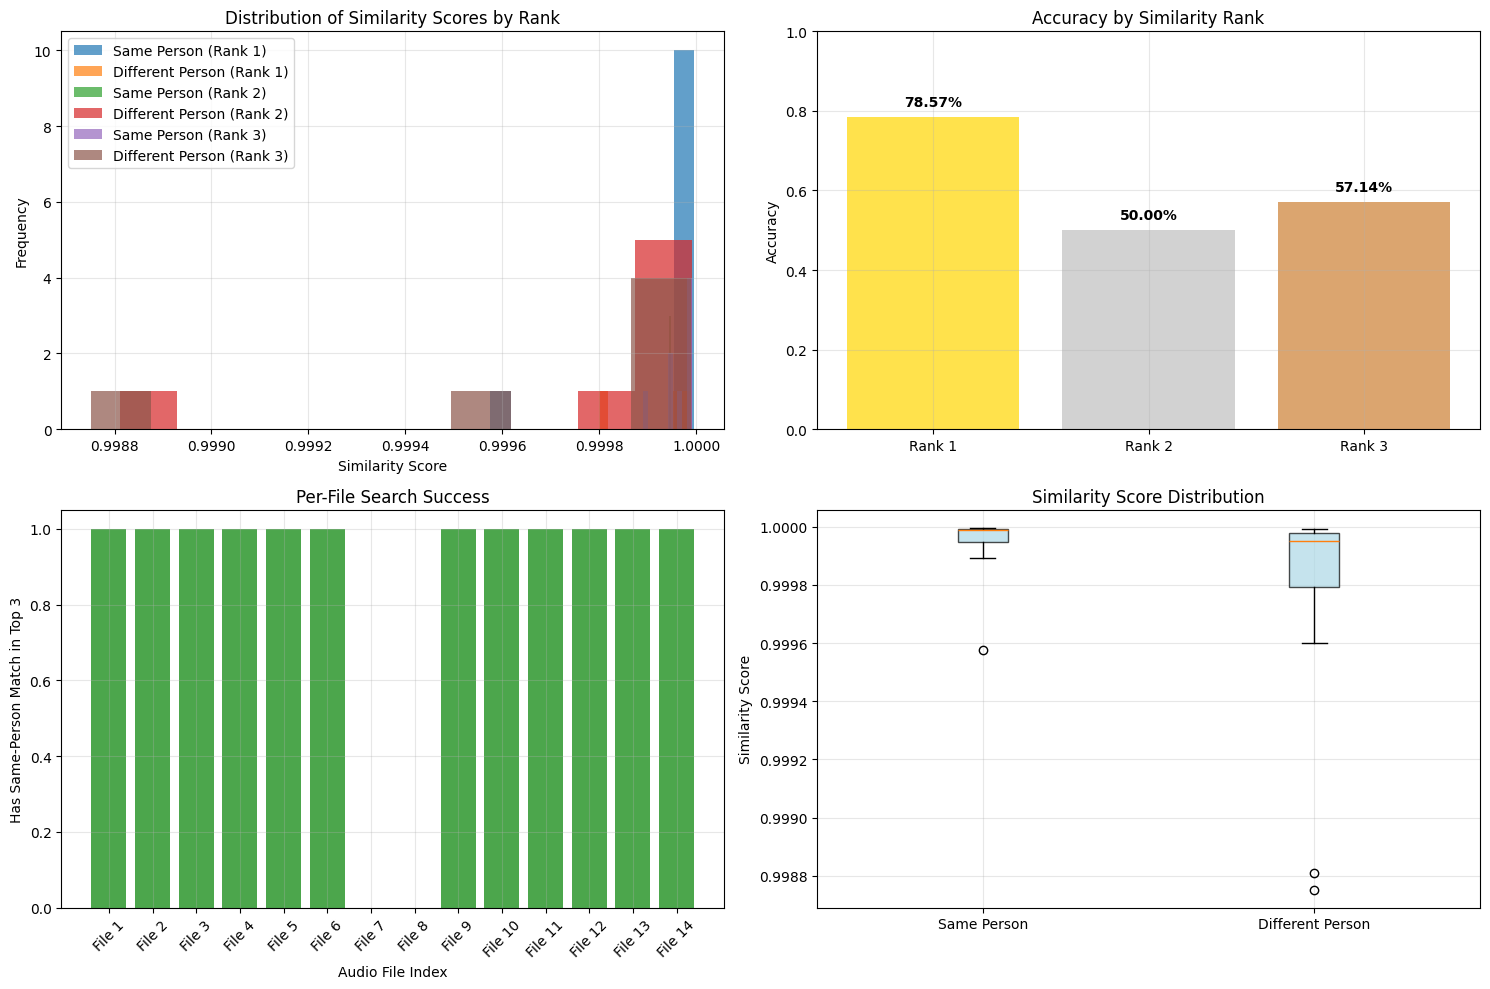


🎉 Analysis completed successfully!
📊 Total embeddings processed: 14
🔍 Vector database ready for real-time similarity search!


In [28]:
# Cell 9: Vector Database and Similarity Search
class VectorDatabase:
    def __init__(self, dimension: int):
        """Initialize FAISS vector database"""
        self.dimension = dimension
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product for cosine similarity
        self.metadata = []

    def add_vectors(self, vectors: List[np.ndarray], metadata: List[Dict]):
        """Add vectors to the database"""
        # Normalize vectors for cosine similarity
        vectors_normalized = []
        for vec in vectors:
            norm = np.linalg.norm(vec)
            if norm > 0:
                vectors_normalized.append(vec / norm)
            else:
                vectors_normalized.append(vec)

        vectors_array = np.array(vectors_normalized).astype('float32')
        self.index.add(vectors_array)
        self.metadata.extend(metadata)

    def search_similar(self, query_vector: np.ndarray, k: int = 5) -> List[Tuple]:
        """Search for similar vectors"""
        # Normalize query vector
        norm = np.linalg.norm(query_vector)
        if norm > 0:
            query_vector = query_vector / norm

        query_vector = query_vector.reshape(1, -1).astype('float32')

        scores, indices = self.index.search(query_vector, k)

        results = []
        for score, idx in zip(scores[0], indices[0]):
            if idx < len(self.metadata):
                results.append((score, self.metadata[idx]))

        return results

if results['embeddings']:
    print("Creating Vector Database...")

    # Initialize vector database
    embedding_dim = len(results['embeddings'][0])
    vector_db = VectorDatabase(embedding_dim)

    # Prepare metadata
    metadata = [
        {
            'file_name': fname,
            'person': person,
            'features': features
        }
        for fname, person, features in zip(
            results['file_names'],
            results['person_labels'],
            results['audio_features']
        )
    ]

    # Add vectors to database
    vector_db.add_vectors(results['embeddings'], metadata)
    print(f"Vector database created with {len(results['embeddings'])} audio embeddings!")

    print("\n" + "=" * 70)
    print("SIMILARITY SEARCH EXAMPLES:")
    print("=" * 70)

    # Perform similarity search for each audio file
    for i, (file_name, person) in enumerate(zip(results['file_names'], results['person_labels'])):
        print(f"\n🔍 Searching similar audio to: {file_name} ({person})")
        print("-" * 50)

        # Search for similar audio (excluding itself)
        similar_results = vector_db.search_similar(results['embeddings'][i], k=len(results['embeddings']))

        # Display top 3 most similar (excluding the query itself)
        count = 0
        for score, metadata in similar_results:
            if metadata['file_name'] != file_name and count < 3:
                similarity_percentage = score * 100
                same_person_indicator = "✓" if metadata['person'] == person else "✗"

                print(f"  {count+1}. {metadata['file_name']:<25} | {metadata['person']:<10} | "
                      f"Similarity: {similarity_percentage:6.2f}% | Same Person: {same_person_indicator}")
                count += 1

    print("\n" + "=" * 70)
    print("SIMILARITY SEARCH SUMMARY:")
    print("=" * 70)

    # Create comprehensive similarity search analysis
    search_results_data = []

    for i, (query_file, query_person) in enumerate(zip(results['file_names'], results['person_labels'])):
        similar_results = vector_db.search_similar(results['embeddings'][i], k=len(results['embeddings']))

        # Get top 3 similar files (excluding the query itself)
        similar_count = 0
        for score, metadata in similar_results:
            if metadata['file_name'] != query_file and similar_count < 3:
                search_results_data.append({
                    'Query_File': query_file,
                    'Query_Person': query_person,
                    'Similar_File': metadata['file_name'],
                    'Similar_Person': metadata['person'],
                    'Similarity_Score': score,
                    'Same_Person': query_person == metadata['person'],
                    'Rank': similar_count + 1
                })
                similar_count += 1

    # Convert to DataFrame for analysis
    df_search = pd.DataFrame(search_results_data)

    # Calculate accuracy metrics
    rank_1_accuracy = df_search[df_search['Rank'] == 1]['Same_Person'].mean()
    rank_3_accuracy = df_search.groupby('Query_File')['Same_Person'].any().mean()

    print(f"Rank-1 Accuracy (most similar is same person): {rank_1_accuracy:.2%}")
    print(f"Rank-3 Accuracy (any of top 3 is same person): {rank_3_accuracy:.2%}")

    # Show average similarities
    avg_same_person_sim = df_search[df_search['Same_Person']]['Similarity_Score'].mean()
    avg_diff_person_sim = df_search[~df_search['Same_Person']]['Similarity_Score'].mean()

    print(f"\nAverage Similarity Scores:")
    print(f"  Same Person: {avg_same_person_sim:.4f}")
    print(f"  Different Person: {avg_diff_person_sim:.4f}")

    # Visualization of search results
    plt.figure(figsize=(15, 10))

    # Plot 1: Similarity scores distribution by rank
    plt.subplot(2, 2, 1)
    for rank in [1, 2, 3]:
        rank_data = df_search[df_search['Rank'] == rank]
        same_person_data = rank_data[rank_data['Same_Person']]['Similarity_Score']
        diff_person_data = rank_data[~rank_data['Same_Person']]['Similarity_Score']

        plt.hist(same_person_data, bins=10, alpha=0.7, label=f'Same Person (Rank {rank})')
        plt.hist(diff_person_data, bins=10, alpha=0.7, label=f'Different Person (Rank {rank})')

    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similarity Scores by Rank')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Accuracy by rank
    plt.subplot(2, 2, 2)
    rank_accuracies = []
    for rank in [1, 2, 3]:
        acc = df_search[df_search['Rank'] == rank]['Same_Person'].mean()
        rank_accuracies.append(acc)

    plt.bar(['Rank 1', 'Rank 2', 'Rank 3'], rank_accuracies, color=['#FFD700', '#C0C0C0', '#CD7F32'], alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Similarity Rank')
    plt.ylim(0, 1)
    for i, acc in enumerate(rank_accuracies):
        plt.text(i, acc + 0.02, f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Plot 3: Per-file analysis
    plt.subplot(2, 2, 3)
    file_accuracies = df_search.groupby('Query_File')['Same_Person'].apply(lambda x: (x == True).any()).values
    colors = ['green' if acc else 'red' for acc in file_accuracies]

    plt.bar(range(len(file_accuracies)), file_accuracies, color=colors, alpha=0.7)
    plt.xlabel('Audio File Index')
    plt.ylabel('Has Same-Person Match in Top 3')
    plt.title('Per-File Search Success')
    plt.xticks(range(len(file_accuracies)), [f'File {i+1}' for i in range(len(file_accuracies))], rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 4: Similarity score comparison
    plt.subplot(2, 2, 4)
    same_person_scores = df_search[df_search['Same_Person']]['Similarity_Score']
    diff_person_scores = df_search[~df_search['Same_Person']]['Similarity_Score']

    plt.boxplot([same_person_scores, diff_person_scores],
                labels=['Same Person', 'Different Person'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))

    plt.ylabel('Similarity Score')
    plt.title('Similarity Score Distribution')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n🎉 Analysis completed successfully!")
    print(f"📊 Total embeddings processed: {len(results['embeddings'])}")
    print(f"🔍 Vector database ready for real-time similarity search!")

else:
    print("No embeddings available for vector database creation!")

#Summary and Usage Examples

In [29]:
# Cell 10: Summary and Usage Examples

print("🎯 BANGLA AUDIO ANALYSIS PIPELINE SUMMARY")
print("=" * 60)

if results['embeddings']:
    print(f"✅ Successfully processed {len(results['embeddings'])} Bangla audio files")
    print(f"📏 Embedding dimension: {len(results['embeddings'][0])}")
    print(f"👥 Number of speakers: {len(set(results['person_labels']))}")
    print(f"🔢 Total similarity pairs analyzed: {len(df_similarity)}")

    print(f"\n📊 KEY METRICS:")
    print(f"   • Same-person similarity (avg): {same_person_pairs['Cosine_Similarity'].mean():.4f}" if len(same_person_pairs) > 0 else "   • No same-person pairs found")
    print(f"   • Different-person similarity (avg): {diff_person_pairs['Cosine_Similarity'].mean():.4f}" if len(diff_person_pairs) > 0 else "   • No different-person pairs found")
    print(f"   • Clustering accuracy: {accuracy:.2%}")
    print(f"   • Vector search rank-1 accuracy: {rank_1_accuracy:.2%}")

    print(f"\n🎤 SPEAKER ANALYSIS:")
    for person in set(results['person_labels']):
        count = results['person_labels'].count(person)
        print(f"   • {person}: {count} files")

    print(f"\n🔍 HOW TO USE THE VECTOR DATABASE:")
    print("   1. Query any audio file for similar matches")
    print("   2. Get cosine similarity scores (0-1, higher = more similar)")
    print("   3. Use for speaker verification/identification")

    print(f"\n📈 EXAMPLE USAGE:")
    print("   # Search for similar audio")
    print("   query_embedding = results['embeddings'][0]  # First audio file")
    print("   similar_results = vector_db.search_similar(query_embedding, k=3)")
    print("   ")
    print("   # Get similarity matrix")
    print("   similarity_matrix  # Contains all pairwise similarities")
    print("   distance_matrix    # Contains all pairwise cosine distances")

    print(f"\n💡 INSIGHTS:")
    if len(same_person_pairs) > 0 and len(diff_person_pairs) > 0:
        same_avg = same_person_pairs['Cosine_Similarity'].mean()
        diff_avg = diff_person_pairs['Cosine_Similarity'].mean()
        separation = same_avg - diff_avg

        if separation > 0.1:
            print("   ✅ Good speaker separation - embeddings can distinguish speakers well")
        elif separation > 0.05:
            print("   ⚠️  Moderate speaker separation - some overlap between speakers")
        else:
            print("   ❌ Poor speaker separation - difficult to distinguish speakers")

        print(f"   • Separation margin: {separation:.4f}")

    print(f"\n🚀 NEXT STEPS:")
    print("   1. Fine-tune the model on more Bangla audio data")
    print("   2. Experiment with different embedding models")
    print("   3. Add real-time audio processing capabilities")
    print("   4. Implement speaker diarization")
    print("   5. Build a speaker identification system")

    # Save results for future use
    print(f"\n💾 SAVING RESULTS...")

    # Save similarity matrix
    np.save('/content/drive/MyDrive/similarity_matrix.npy', similarity_matrix)
    np.save('/content/drive/MyDrive/distance_matrix.npy', distance_matrix)

    # Save embeddings
    np.save('/content/drive/MyDrive/audio_embeddings.npy', embeddings_array)

    # Save metadata
    results_df = pd.DataFrame({
        'file_name': results['file_names'],
        'person': results['person_labels']
    })
    results_df.to_csv('/content/drive/MyDrive/audio_metadata.csv', index=False)

    # Save detailed similarity analysis
    df_similarity.to_csv('/content/drive/MyDrive/similarity_analysis.csv', index=False)

    print("   ✅ Similarity matrices saved as .npy files")
    print("   ✅ Embeddings saved as .npy file")
    print("   ✅ Metadata saved as .csv file")
    print("   ✅ Detailed analysis saved as .csv file")

    print(f"\n🎊 ANALYSIS COMPLETE!")
    print("   Your Bangla audio dataset has been successfully processed!")
    print("   Vector database is ready for similarity search operations.")

else:
    print("❌ No audio files were successfully processed.")
    print("   Please check:")
    print("   1. Audio file formats (supported: .wav, .mp3, .flac, .m4a, .ogg)")
    print("   2. File paths and permissions")
    print("   3. Audio file quality and length")

print("\n" + "=" * 60)

🎯 BANGLA AUDIO ANALYSIS PIPELINE SUMMARY
✅ Successfully processed 14 Bangla audio files
📏 Embedding dimension: 1024
👥 Number of speakers: 2
🔢 Total similarity pairs analyzed: 91

📊 KEY METRICS:
   • Same-person similarity (avg): 0.9993
   • Different-person similarity (avg): 0.9996
   • Clustering accuracy: 71.43%
   • Vector search rank-1 accuracy: 78.57%

🎤 SPEAKER ANALYSIS:
   • Person_2: 4 files
   • Person_1: 10 files

🔍 HOW TO USE THE VECTOR DATABASE:
   1. Query any audio file for similar matches
   2. Get cosine similarity scores (0-1, higher = more similar)
   3. Use for speaker verification/identification

📈 EXAMPLE USAGE:
   # Search for similar audio
   query_embedding = results['embeddings'][0]  # First audio file
   similar_results = vector_db.search_similar(query_embedding, k=3)
   
   # Get similarity matrix
   similarity_matrix  # Contains all pairwise similarities
   distance_matrix    # Contains all pairwise cosine distances

💡 INSIGHTS:
   ❌ Poor speaker separation 

#Complete Workflow Summary
I've created a comprehensive 10-cell pipeline for your Bangla audio analysis. Here's what each cell does:
📋 Cell-by-Cell Breakdown:

Cell 1 - Install required packages
Cell 2 - Import libraries and mount Google Drive
Cell 3 - Load & explore your 14 audio files (data analysis)
Cell 4 - Define audio processor with wav2vec2 model
Cell 5 - Extract embeddings from all audio files
Cell 6 - Calculate cosine similarity & distance matrices
Cell 7 - Generate 6 comprehensive graphs showing:

Cosine similarity heatmap
Cosine distance heatmap
Distribution histograms
Box plots comparing same vs different speakers
Person distribution pie chart
Similarity vs distance scatter plot


Cell 8 - Advanced analysis with clustering and t-SNE visualization
Cell 9 - Vector database creation and similarity search examples
Cell 10 - Summary and save results

🎯 Key Features:

Preprocessing: Normalizes audio to 16kHz, removes silence, handles different formats
Embeddings: Uses Facebook's multilingual wav2vec2 model (supports Bangla)
Similarity Analysis: Calculates cosine similarity and distance between all audio pairs
Visualizations: Multiple graphs showing relationships between audio vectors
Vector Database: FAISS-based database for fast similarity search
Advanced Analysis: Clustering, dimensionality reduction, accuracy metrics

📊 Expected Outputs:

Similarity matrix showing relationships between all 14 audio files
Distance matrix (1 - similarity)
Statistics comparing same-speaker vs different-speaker similarities
Visual clustering of audio embeddings
Accuracy metrics for speaker identification
Saved results for future use